In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

import sys  
# use Constantin's utils =)
sys.path.append('../quantum-computing/python/src')
import state_preparation_util

In [2]:
MIN_NUM = 0
MAX_NUM = 15

print("Quantum implementation of Bernstein–Vazirani algorithm for guessing game.")

Quantum implementation of Bernstein–Vazirani algorithm for guessing game.


In [3]:
print("Randomly picking a secret number between %d and %d...  " %(MIN_NUM, MAX_NUM))
# Generate a random integer
secret = random.randint(MIN_NUM, MAX_NUM)

print("(Secret number chosen is %d)" %(secret))

Randomly picking a secret number between 0 and 15...  
(Secret number chosen is 3)


In [4]:
secret_as_binary = format(secret, "b")
print("(Secret number in binary is %s)" %(secret_as_binary))
search_space_size = MAX_NUM.bit_length()
print("Size of search space is %d bits." %(search_space_size))

(Secret number in binary is 11)
Size of search space is 4 bits.


In [5]:
# Pad secret with leading 0 as needed to ensure it has the same number of bit indices as the search space 
delta = search_space_size - len(secret_as_binary)
secret_as_binary = ("0" * delta) + secret_as_binary

======== Quantum State ========
0 00000 1.0 (1+0j)


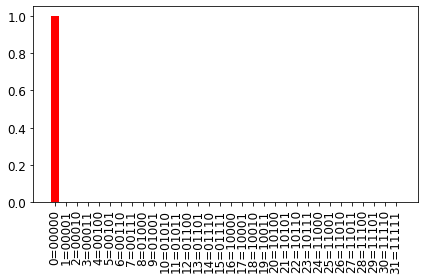

Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2))


In [6]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(search_space_size+1, search_space_size)

state_preparation_util.run_print_plot(bv_circuit)

======== Quantum State ========
0 00000 0.5 (0.70711+0j)
16 10000 0.5 (0.70711+0j)


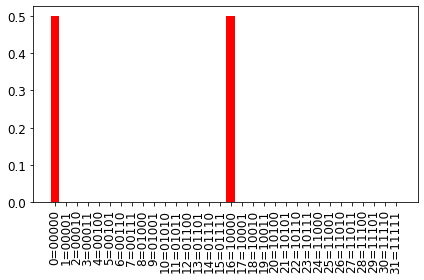

Statevector([ 0.70710678+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.70710678+0.j, -0.        +0.j,
             -0.        +0.j, -0.        +0.j, -0.        +0.j,
             -0.        +0.j, -0.        +0.j, -0.        +0.j,
             -0.        +0.j, -0.        +0.j, -0.        +0.j,
             -0.        +0.j, -0.        +0.j, -0.        +0.j,
             -0.        +0.j, -0.        +0.j],
            dims=(2, 2, 2, 2, 2))


In [7]:
# put auxiliary in state |->
bv_circuit.h(search_space_size)
state_preparation_util.run_print_plot(bv_circuit)

======== Quantum State ========
0 00000 0.5 (0.70711+0j)
16 10000 0.5 (-0.70711-0j)


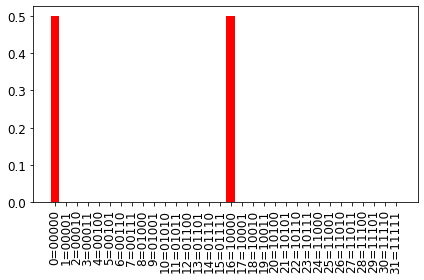

Statevector([ 0.70710678+0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.70710678-8.65956056e-17j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
             -0.        +0.00000000e+00j, -0.        +0.00000000e+00j,
      

In [8]:
bv_circuit.z(search_space_size)
state_preparation_util.run_print_plot(bv_circuit)

======== Quantum State ========
0 00000 0.03125 (0.17678+0j)
1 00001 0.03125 (0.17678+0j)
2 00010 0.03125 (0.17678+0j)
3 00011 0.03125 (0.17678+0j)
4 00100 0.03125 (0.17678+0j)
5 00101 0.03125 (0.17678+0j)
6 00110 0.03125 (0.17678+0j)
7 00111 0.03125 (0.17678+0j)
8 01000 0.03125 (0.17678+0j)
9 01001 0.03125 (0.17678+0j)
10 01010 0.03125 (0.17678+0j)
11 01011 0.03125 (0.17678+0j)
12 01100 0.03125 (0.17678+0j)
13 01101 0.03125 (0.17678+0j)
14 01110 0.03125 (0.17678+0j)
15 01111 0.03125 (0.17678+0j)
16 10000 0.03125 (-0.17678-0j)
17 10001 0.03125 (-0.17678-0j)
18 10010 0.03125 (-0.17678-0j)
19 10011 0.03125 (-0.17678-0j)
20 10100 0.03125 (-0.17678-0j)
21 10101 0.03125 (-0.17678-0j)
22 10110 0.03125 (-0.17678-0j)
23 10111 0.03125 (-0.17678-0j)
24 11000 0.03125 (-0.17678-0j)
25 11001 0.03125 (-0.17678-0j)
26 11010 0.03125 (-0.17678-0j)
27 11011 0.03125 (-0.17678-0j)
28 11100 0.03125 (-0.17678-0j)
29 11101 0.03125 (-0.17678-0j)
30 11110 0.03125 (-0.17678-0j)
31 11111 0.03125 (-0.17678-0j)


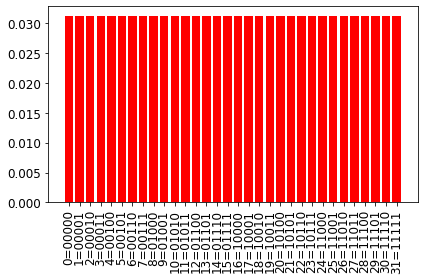

Statevector([ 0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j,  0.1767767+0.00000000e+00j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014

In [9]:
# Apply Hadamard gates before querying the oracle
for i in range(search_space_size):
    bv_circuit.h(i)
state_preparation_util.run_print_plot(bv_circuit)


======== Quantum State ========
0 00000 0.03125 (0.17678+0j)
1 00001 0.03125 (-0.17678-0j)
2 00010 0.03125 (-0.17678-0j)
3 00011 0.03125 (0.17678+0j)
4 00100 0.03125 (0.17678+0j)
5 00101 0.03125 (-0.17678-0j)
6 00110 0.03125 (-0.17678-0j)
7 00111 0.03125 (0.17678+0j)
8 01000 0.03125 (0.17678+0j)
9 01001 0.03125 (-0.17678-0j)
10 01010 0.03125 (-0.17678-0j)
11 01011 0.03125 (0.17678+0j)
12 01100 0.03125 (0.17678+0j)
13 01101 0.03125 (-0.17678-0j)
14 01110 0.03125 (-0.17678-0j)
15 01111 0.03125 (0.17678+0j)
16 10000 0.03125 (-0.17678-0j)
17 10001 0.03125 (0.17678+0j)
18 10010 0.03125 (0.17678+0j)
19 10011 0.03125 (-0.17678-0j)
20 10100 0.03125 (-0.17678-0j)
21 10101 0.03125 (0.17678+0j)
22 10110 0.03125 (0.17678+0j)
23 10111 0.03125 (-0.17678-0j)
24 11000 0.03125 (-0.17678-0j)
25 11001 0.03125 (0.17678+0j)
26 11010 0.03125 (0.17678+0j)
27 11011 0.03125 (-0.17678-0j)
28 11100 0.03125 (-0.17678-0j)
29 11101 0.03125 (0.17678+0j)
30 11110 0.03125 (0.17678+0j)
31 11111 0.03125 (-0.17678-0j)


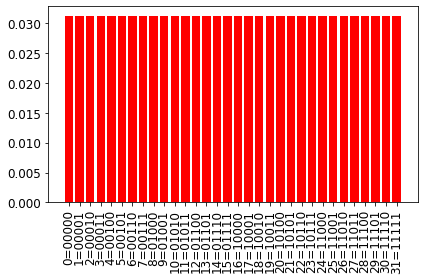

Statevector([ 0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014e-17j,  0.1767767+0.00000000e+00j,
              0.1767767+0.00000000e+00j, -0.1767767-2.16489014e-17j,
             -0.1767767-2.16489014

In [10]:
# Apply barrier 
bv_circuit.barrier()

# reverse secret to fit qiskit's least significant bit (LSB) first ordering
lsb_first_secret = secret_as_binary[::-1]

# Apply the inner-product oracle
for q in range(search_space_size):
    if lsb_first_secret[q] == '1':
        bv_circuit.cx(q, search_space_size)
        
# Apply barrier 
bv_circuit.barrier()

state_preparation_util.run_print_plot(bv_circuit)

In [11]:
# Apply Hadamard gates after querying the oracle
for i in range(search_space_size):
    bv_circuit.h(i)

bv_circuit.draw()

┌───┐      ░            ░ ┌───┐
q_0: ┤ H ├──────░───■────────░─┤ H ├
     ├───┤      ░   │        ░ ├───┤
q_1: ┤ H ├──────░───┼────■───░─┤ H ├
     ├───┤      ░   │    │   ░ ├───┤
q_2: ┤ H ├──────░───┼────┼───░─┤ H ├
     ├───┤      ░   │    │   ░ ├───┤
q_3: ┤ H ├──────░───┼────┼───░─┤ H ├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘
q_4: ┤ H ├┤ Z ├─░─┤ X ├┤ X ├─░──────
     └───┘└───┘ ░ └───┘└───┘ ░      
c: 4/═══════════════════════════════

======== Quantum State ========
3 00011 0.5 (0.70711-0j)
19 10011 0.5 (-0.70711+0j)


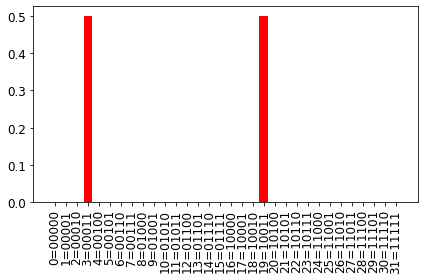

Statevector([ 3.92523115e-17-4.32978028e-17j,
              9.47634627e-17+4.32978028e-17j,
              1.01938147e-16+4.32978028e-17j,
              7.07106781e-01-1.29893408e-16j,
             -1.96261557e-17+4.62449107e-33j,
              8.12941988e-18+1.44940717e-33j,
             -8.12941988e-18+6.16465893e-33j,
             -4.32205119e-18+4.32978028e-17j,
             -1.96261557e-17+2.35415736e-33j,
              8.12941988e-18+2.53242438e-33j,
             -8.12941988e-18+6.89030637e-33j,
              2.29934717e-17+4.32978028e-17j,
              1.54074396e-33-4.01889348e-33j,
             -3.02550168e-33+4.97783402e-34j,
              4.16972083e-33-4.21746836e-33j,
              1.14967359e-17-4.90694553e-33j,
              5.55111512e-17-4.32978028e-17j,
             -1.04576541e-16-4.32978028e-17j,
             -1.21564303e-16-4.32978028e-17j,
             -7.07106781e-01+1.29893408e-16j,
              9.84376111e-35+2.93939116e-33j,
              1.68365798e-18-5.732

In [12]:
state_preparation_util.run_print_plot(bv_circuit)